# wave net 
Try to predict audio sequencies, 

Auto agresive 

try to predict next char 

tree like herachical maner, we fuze the informtaion from the previous context  slowly, when we get deeper 

progressive fuzion 

make network deeper and in each level we want to fuzze two consactivate elements  
 - to char, then 
 - to biagrams, then
 - to 3th grams and so on ..



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [37]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [41]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(f'{[itos[ix.item()] for ix in x]}--->{itos[y.item()]}')

['.', '.', '.', '.', '.', '.', '.', '.']--->e
['.', '.', '.', '.', '.', '.', '.', 'e']--->b
['.', '.', '.', '.', '.', '.', 'e', 'b']--->r
['.', '.', '.', '.', '.', 'e', 'b', 'r']--->i
['.', '.', '.', '.', 'e', 'b', 'r', 'i']--->m
['.', '.', '.', 'e', 'b', 'r', 'i', 'm']--->a
['.', '.', 'e', 'b', 'r', 'i', 'm', 'a']--->.
['.', '.', '.', '.', '.', '.', '.', '.']--->h
['.', '.', '.', '.', '.', '.', '.', 'h']--->i
['.', '.', '.', '.', '.', '.', 'h', 'i']--->l
['.', '.', '.', '.', '.', 'h', 'i', 'l']--->t
['.', '.', '.', '.', 'h', 'i', 'l', 't']--->o
['.', '.', '.', 'h', 'i', 'l', 't', 'o']--->n
['.', '.', 'h', 'i', 'l', 't', 'o', 'n']--->.
['.', '.', '.', '.', '.', '.', '.', '.']--->j
['.', '.', '.', '.', '.', '.', '.', 'j']--->h
['.', '.', '.', '.', '.', '.', 'j', 'h']--->e
['.', '.', '.', '.', '.', 'j', 'h', 'e']--->n
['.', '.', '.', '.', 'j', 'h', 'e', 'n']--->e
['.', '.', '.', 'j', 'h', 'e', 'n', 'e']--->.


In [98]:
class Linear:
    def __init__(self, in_fetures, out_fetures, bias=True): #fanin fanout
        self.weight = torch.randn((in_fetures, out_fetures)) /(in_fetures**0.5)
        self.bias = torch.randn(out_fetures) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, in_features, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.learning_mode = True
        self.momentum = momentum
        
        self.gamma = torch.ones((1, in_features))
        self.beta = torch.zeros((1, in_features))        
        
        self.bnmean_running = torch.ones((1, in_features))
        self.bnvar_running = torch.zeros((1, in_features))

    def __call__(self, x):
        if self.learning_mode:
            if x.ndim == 2:
                dim = 0
            elif x.ndim==3:
                dim = (0,1)

            meani = x.mean(dim, keepdim=True)
            vari = x.var(dim, keepdim=True)
            self.out = self.gamma * (x-meani)/torch.sqrt(vari + self.eps) + self.beta
            with torch.no_grad():
                self.bnmean_running = (1-self.momentum) * self.bnmean_running + self.momentum * meani
                self.bnvar_running = (1-self.momentum) * self.bnvar_running + self.momentum * vari
        
        else: 
            self.out = self.gamma * (x-self.bnmean_running)/torch.sqrt(self.bnvar_running + self.eps) + self.beta

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
            
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]

class FlatternConsecutive:    
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view((B, T//self.n, C*self.n))

        if x.shape[1]==1:
            x = x.squeeze(1)
        self.out = x # view is very cheep in torch becouse its not alacoete new memory 
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]


In [102]:
torch.manual_seed(42)

In [103]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP


model = Sequential([
  Embedding(vocab_size, n_embd), 
  FlatternConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlatternConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlatternConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  
  Linear(n_hidden, vocab_size)
])

# with torch.no_grad():
#   model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [104]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    if i%10000==0:
        print(f'{loss=}')
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = -0.1 if i <150000 else -0.01
    for p in parameters:
        p.data += lr * p.grad 

    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d} {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
    

loss=tensor(4.0528, grad_fn=<NllLossBackward0>)
      0/ 200000 4.0528
   1000/ 200000 2.4506
   2000/ 200000 2.2692
   3000/ 200000 2.2874
   4000/ 200000 2.9269
   5000/ 200000 2.5494
   6000/ 200000 2.2390
   7000/ 200000 2.0130
   8000/ 200000 1.8556
   9000/ 200000 1.9130
loss=tensor(2.1578, grad_fn=<NllLossBackward0>)
  10000/ 200000 2.1578
  11000/ 200000 2.2118
  12000/ 200000 1.8797
  13000/ 200000 2.5067
  14000/ 200000 1.6593
  15000/ 200000 2.7384
  16000/ 200000 2.3593
  17000/ 200000 2.1655
  18000/ 200000 1.8675
  19000/ 200000 2.0094
loss=tensor(2.5660, grad_fn=<NllLossBackward0>)
  20000/ 200000 2.5660
  21000/ 200000 1.8608
  22000/ 200000 2.3028
  23000/ 200000 2.2074
  24000/ 200000 1.8252
  25000/ 200000 2.3777
  26000/ 200000 1.9705
  27000/ 200000 2.2634
  28000/ 200000 1.8007
  29000/ 200000 1.8279
loss=tensor(1.7431, grad_fn=<NllLossBackward0>)
  30000/ 200000 1.7431
  31000/ 200000 2.3288
  32000/ 200000 2.1694
  33000/ 200000 2.5838
  34000/ 200000 1.8304
  3

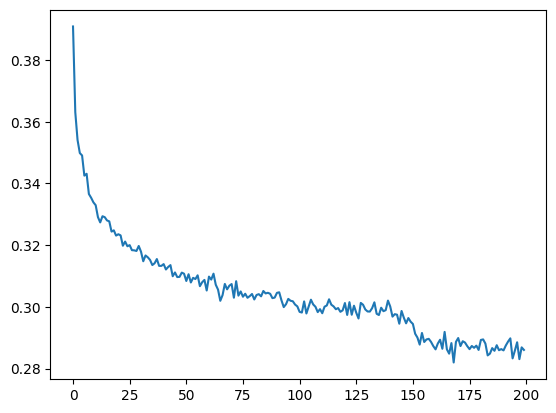

In [106]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [107]:
for layer in model.layers:
    layer.learning_mode = False

In [108]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.911248803138733
val 2.0149857997894287


In [93]:
#batch norm bag 
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)
evar = e.var(0, keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [94]:
model.layers[3].bnmean_running.shape

torch.Size([1, 4, 68])

In [96]:
e.mean(0, keepdim=True).shape

torch.Size([1, 4, 68])

In [97]:
e.mean((0, 1), keepdim=True).shape

torch.Size([1, 1, 68])

In [83]:
# wave net 

ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  3, 15, 12, 20, 18,  1],
        [ 0,  0,  0,  0,  0, 20, 25, 18],
        [ 0,  0,  0,  0, 15, 13,  1, 18]])

In [57]:
print(model.layers[0].out.shape) 
# embedding layer, for ech character have 10 dementional vactor, witch we are tring to learn
# plags out the embedding vactor for each one of this integeers 

torch.Size([4, 8, 10])


In [58]:
print(model.layers[1].out.shape) # flatten layer 
# it views this tensor as 4x80 tensor 
# all this 10 demensional embeddings, all this 8 characters, just end up being strech up in to a long row 
# a bit like concataonation operation 

torch.Size([4, 80])


In [56]:
print(model.layers[2].out.shape) # Linear layer 
# takes 80 and creates 200 chanegl just by matrix mult 

torch.Size([4, 200])


In [61]:
(torch.randn((4,80)) @ torch.randn((80, 200)) + torch.randn((200))).shape

torch.Size([4, 200])

In [66]:
# (4,80) dosnt need to be 2d 
# @ in pytoch is powerfool
# only last one, left unchange  
(torch.randn((4, 5, 6, 80)) @ torch.randn((80, 200)) + torch.randn((200))).shape

torch.Size([4, 5, 6, 200])

In [67]:
# (1 2) (3 4) (5 6) (7 8) (9 10)
# four groups of two, and each one of it is 10d vector 
# we need to change flatten layer 
(torch.randn((4, 4, 20)) @ torch.randn((20, 200)) + torch.randn((200))).shape

torch.Size([4, 4, 200])

In [68]:
e = torch.randn(4, 8, 10) # goal: whant to be 4, 4, 20 where 10d vectos are concataena
e.view(4, -1).shape # currently

torch.Size([4, 80])

In [73]:
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape # gives all even character and after that all add caracters 
expl = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

In [76]:
(e.view(4,4,20) == expl).all()

tensor(True)

In [45]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    if i%10000==0:
        print(f'{loss=}')
    
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = -0.1 if i <150000 else -0.01
    for p in parameters:
        p.data += lr * p.grad 

    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d} {loss.item():.4f}')
    
    lossi.append(loss.log10().item())
    break

loss=tensor(4.3713, grad_fn=<NllLossBackward0>)
      0/ 200000 4.3713


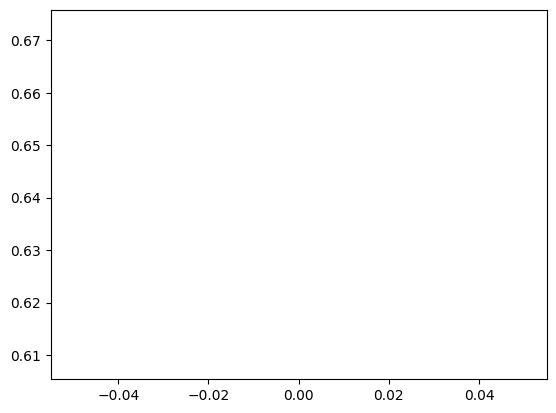

In [46]:
plt.plot(lossi)

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 14994

In [35]:
for layer in model.layers:
    layer.learning_mode = False

In [36]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.3541018962860107
val 2.352419376373291
